![title](birds-nest-4-eggs.png)

###### image:https://www.publicdomainpictures.net/nl/view-image.php?image=61631&picture=vogels-nest-4-eieren

#   The effect of precipitation between March and July on the breeding of birds in the Netherlands 1990-2020 in changes compared to the year before.

Sources:

Dutch bird breeding per season as percentage compared to indexyear (all years and all birds manually selected):
https://opendata.cbs.nl/statline/#/CBS/nl/dataset/84498NED/table?ts=1673294982549

Monthly sum of precipitation in 0.1 mm (ROYAL NETHERLANDS METEOROLOGICAL INSTITUTE):
###### De Kooy: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_235_rh24.txt
###### De Bilt: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_260_rh24.txt
###### Leeuwarden: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_270_rh24.txt
###### Eelde: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_280_rh24.txt
###### Twenthe: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_290_rh24.txt
###### Schiphol: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_240_rh24.txt
###### Rotterdam: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_344_rh24.txt
###### Vlissingen: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_310_rh24.txt
###### Eindhoven: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_370_rh24.txt
###### Maastricht/Beek: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/maandgegevens/mndgeg_380_rh24.txt

###### *Coordinates for the stations: http://climexp.knmi.nl/KNMIData/list_dx.txt






In [1]:
#Importing all necessary libraries
import pandas as pd
import functions_final_assignment as fn

In [2]:
#Loading in the files with a yaml config file
config = fn.yaml_config()
#Loading the data into a dataframe
precipitation_df = fn.load_concat_df(config["precipitation"])
birds_df = pd.read_excel(io=config["breedingbirds"],sheet_name="Provinciale trends 1990-2020",skiprows=2)

In [3]:
#show the dataframe for precipitation
precipitation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 954 entries, 0 to 117
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   STN     954 non-null    int64 
 1   YYYY    954 non-null    int64 
 2      JAN  954 non-null    object
 3      FEB  954 non-null    object
 4      MAR  954 non-null    object
 5      APR  954 non-null    object
 6      MAY  954 non-null    object
 7      JUN  954 non-null    object
 8      JUL  954 non-null    object
 9      AUG  954 non-null    object
 10     SEP  954 non-null    object
 11     OCT  954 non-null    object
 12     NOV  954 non-null    object
 13     DEC  954 non-null    object
 14    YEAR  954 non-null    object
dtypes: int64(2), object(13)
memory usage: 119.2+ KB


In [4]:
precipitation_df.head(10)


,STN,YYYY,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,YEAR
0,240,1951,,,,,,,,,,,,,
1,240,1952,,,,,,,,,,,,,
2,240,1953,,,,,,,,,,,,,
3,240,1954,,,,,,,,,,,,,
4,240,1955,,,,,,,,,,,,,
5,240,1956,,,,,,,,,,,,,
6,240,1957,,,,,,,,,,,,,
7,240,1958,,,,,,,,,,,,,
8,240,1959,,,,,,,,,,,,,
9,240,1960,,,,,,,,,,,,,


The precipitation data starts well before 1990, as we only need the data between 1990 and 2020 we can get rid of most data.
After that the amount of missing values may be calculated.

In [5]:
#select only the rows with the values in the YYYY column between 1990 and 2020
precipitation_df = precipitation_df[precipitation_df.YYYY.between(1990,2020)]
#Show the unique values for YYYY to see if the YYYY filtering is done correctly
print(f'{precipitation_df.YYYY.unique()}')


[1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020]


In [6]:
#Calculated the amount of missing values
print(f'The amount of missing values are:\n {precipitation_df.isnull().sum()}')


The amount of missing values are:
 STN       0
YYYY      0
   JAN    0
   FEB    0
   MAR    0
   APR    0
   MAY    0
   JUN    0
   JUL    0
   AUG    0
   SEP    0
   OCT    0
   NOV    0
   DEC    0
  YEAR    0
dtype: int64


In [7]:
#convert all values to integers:

precipitation_df = precipitation_df.astype(int)

In [8]:
#Adding the location at which the station is found to the dataframe
stn_dict = fn.make_stn_dict(config["stn_coord"])
precipitation_df["COORD"] = [stn_dict[str(s)] for s in precipitation_df.STN]
precipitation_df.head()

,STN,YYYY,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,YEAR,COORD
39,240,1990,463,1136,203,417,193,824,295,741,1157,601,1082,465,7577,"52.32N,4.78E,-4.2m"
40,240,1991,459,282,230,383,280,1134,563,295,834,462,1268,506,6696,"52.32N,4.78E,-4.2m"
41,240,1992,463,301,788,386,388,562,641,1357,579,1253,1228,614,8560,"52.32N,4.78E,-4.2m"
42,240,1993,850,258,84,397,712,533,1617,669,1414,765,638,1478,9415,"52.32N,4.78E,-4.2m"
43,240,1994,863,256,998,791,430,453,407,828,1472,1361,420,1256,9535,"52.32N,4.78E,-4.2m"


In [9]:
#As we want to see the sum for precipitation between march and july
#A column will be added
precipitation_df["MAR-JUL"] = precipitation_df.iloc[:,4:9].T.sum()
precipitation_df.head()

,STN,YYYY,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,YEAR,COORD,MAR-JUL
39,240,1990,463,1136,203,417,193,824,295,741,1157,601,1082,465,7577,"52.32N,4.78E,-4.2m",1932
40,240,1991,459,282,230,383,280,1134,563,295,834,462,1268,506,6696,"52.32N,4.78E,-4.2m",2590
41,240,1992,463,301,788,386,388,562,641,1357,579,1253,1228,614,8560,"52.32N,4.78E,-4.2m",2765
42,240,1993,850,258,84,397,712,533,1617,669,1414,765,638,1478,9415,"52.32N,4.78E,-4.2m",3343
43,240,1994,863,256,998,791,430,453,407,828,1472,1361,420,1256,9535,"52.32N,4.78E,-4.2m",3079


mu (robust) = 2865.0, sigma (robust) = 663.27


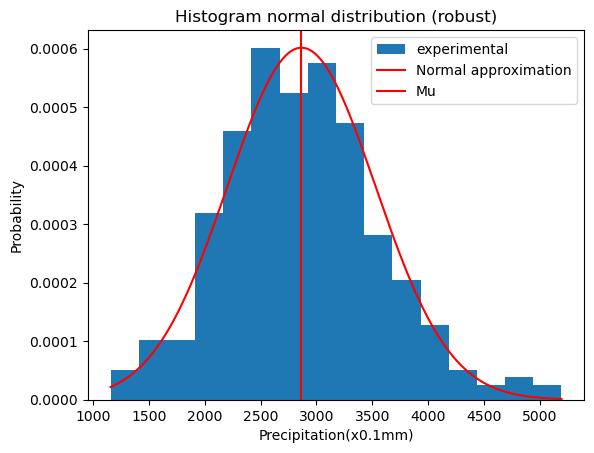

In [10]:
#plot to see if the 
fn.hist_robust_norm(precipitation_df["MAR-JUL"])